In [2]:
import os
from pathlib import Path
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import tifffile as tiff
import torchvision.models as models
import wandb
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# ===== PATHS =====
HS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\train\HS"
TEST_HS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\val\HS"
CHECKPOINT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints"
CKPT_PATH = os.path.join(CHECKPOINT_DIR, "best_hs125_resnet18.pth")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===== DATA SETTINGS =====
TARGET_BANDS = 125
TARGET_HW = (64, 64)       # Resizing to 64x64 for consistency

# ===== SPLIT =====
VAL_RATIO = 0.2
SEED = 42

# ===== TRAIN =====
EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-4
WD = 1e-4
NUM_WORKERS = 0


In [3]:
# ===== REPRODUCIBILITY =====
import random

def set_seed(seed=42):
    """Set seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    
    # Make PyTorch deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for CUDA
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"✓ Random seed set to {seed} for reproducibility")

# Apply seed
set_seed(SEED)

✓ Random seed set to 42 for reproducibility


In [4]:
prefixes = sorted({
    fn.split("_")[0]
    for fn in os.listdir(HS_DIR)
    if fn.endswith(".tif")
})

print("MS classes:", prefixes)
print("NUM_CLASSES =", len(prefixes))

MS classes: ['Health', 'Other', 'Rust']
NUM_CLASSES = 3


In [5]:
from tqdm import tqdm

# ===============================================================
# Robust CHW conversion  (dùng chung cho stats / train / test)
# ===============================================================
def ensure_chw(arr: np.ndarray, expected_bands: int) -> np.ndarray:
    """
    Đảm bảo array có dạng (C, H, W).
    Quy tắc:
      - 2-D  -> (1, H, W)
      - 3-D  -> so sánh shape[0] vs shape[2]:
          * Nếu shape[2] == expected_bands            -> HWC, transpose
          * Nếu shape[0] == expected_bands            -> đã CHW
          * Nếu cả 2 != expected_bands                -> chọn dim nhỏ nhất làm C
    """
    if arr.ndim == 2:
        return arr[None, :, :]

    if arr.ndim != 3:
        raise ValueError(f"Expected 2-D or 3-D array, got {arr.ndim}-D")

    d0, d1, d2 = arr.shape

    # Trường hợp rõ ràng
    if d2 == expected_bands and d0 != expected_bands:
        return np.transpose(arr, (2, 0, 1))         # HWC -> CHW
    if d0 == expected_bands and d2 != expected_bands:
        return arr                                    # CHW rồi

    # Cả 2 chiều == expected_bands (vuông): ưu tiên CHW (dim-0 = C)
    if d0 == expected_bands and d2 == expected_bands:
        return arr  # giữ nguyên, coi dim-0 là C

    # Không chiều nào == expected_bands: chọn dim nhỏ nhất làm C
    dims = [d0, d1, d2]
    c_axis = int(np.argmin(dims))
    if c_axis == 2:
        return np.transpose(arr, (2, 0, 1))
    elif c_axis == 1:
        return np.transpose(arr, (1, 0, 2))
    else:
        return arr


def fix_bands(arr: np.ndarray, target_bands: int) -> np.ndarray:
    """Cắt hoặc pad bands. Pad bằng mean spatial (tránh tín hiệu giả)."""
    c = arr.shape[0]
    if c > target_bands:
        return arr[:target_bands]
    if c < target_bands:
        pad = np.repeat(
            arr.mean(axis=0, keepdims=True),    # mean spatial
            target_bands - c, axis=0
        ).astype(arr.dtype)
        return np.concatenate([arr, pad], axis=0)
    return arr


def clip_per_band(x: torch.Tensor, ql=0.01, qh=0.99) -> torch.Tensor:
    """Clip mỗi band theo quantile q1/q99. Input/output: (C, H, W)."""
    C = x.shape[0]
    flat = x.view(C, -1)
    lo = torch.quantile(flat, ql, dim=1).view(-1, 1, 1)
    hi = torch.quantile(flat, qh, dim=1).view(-1, 1, 1)
    return torch.clamp(x, lo, hi)


# ===============================================================
# Compute global stats  (match pipeline: ensure_chw → fix_bands
#                         → resize → clip_per_band → accumulate)
# ===============================================================
@torch.no_grad()
def compute_global_stats_matched(
    img_dir,
    file_list,
    target_bands=125,
    target_hw=(64, 64),
    clip_q=(0.01, 0.99),
    eps=1e-8,
    max_files=None,
):
    ql, qh = clip_q
    sum_c   = torch.zeros(target_bands, dtype=torch.float64)
    sumsq_c = torch.zeros(target_bands, dtype=torch.float64)
    count   = 0

    files = file_list if max_files is None else file_list[:max_files]

    for fname in tqdm(files, desc="Computing stats"):
        path = os.path.join(img_dir, fname)
        arr = tiff.imread(path).astype(np.float32)

        arr = ensure_chw(arr, target_bands)
        arr = fix_bands(arr, target_bands)

        x = torch.from_numpy(arr)  # (C, H, W)

        # Resize
        if x.shape[1:] != target_hw:
            x = F.interpolate(x.unsqueeze(0), size=target_hw,
                              mode="bilinear", align_corners=False).squeeze(0)

        # Clip per-band
        x = clip_per_band(x, ql, qh)

        # Accumulate
        sum_c   += x.sum(dim=(1, 2), dtype=torch.float64)
        sumsq_c += (x * x).sum(dim=(1, 2), dtype=torch.float64)
        count   += x.shape[1] * x.shape[2]

    mean = (sum_c / (count + eps)).to(torch.float32)
    var  = (sumsq_c / (count + eps) - mean.double()**2).clamp_min(0.0).to(torch.float32)
    std  = torch.sqrt(var + eps)

    return mean.cpu().numpy(), std.cpu().numpy()


def label_from_filename(fname: str) -> str:
    return os.path.basename(fname).split("_")[0]


In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import tifffile as tiff

TARGET_BANDS = 125

def to_chw(arr: np.ndarray, expected_bands: int = 125) -> np.ndarray:
    """
    Đưa ảnh về dạng (C,H,W) từ các dạng phổ biến:
    - (H,W,C)
    - (C,H,W)
    - (H,W) (hiếm)
    """
    if arr.ndim == 2:
        # (H,W) -> (1,H,W)
        return arr[None, :, :]

    if arr.ndim != 3:
        raise ValueError(f"Unsupported ndim={arr.ndim}, shape={arr.shape}")

    a, b, c = arr.shape

    # Nếu đang HWC và C khớp expected hoặc rất gần expected
    if c == expected_bands or c == expected_bands + 1 or c == expected_bands - 1:
        return np.transpose(arr, (2, 0, 1))  # HWC -> CHW

    # Nếu đang CHW và C khớp expected hoặc gần expected
    if a == expected_bands or a == expected_bands + 1 or a == expected_bands - 1:
        return arr  # đã CHW

    # Heuristic: chọn chiều nhỏ nhất làm channel (thường C nhỏ hơn H,W nếu ảnh lớn)
    # Nhưng với case 32x32x125 thì C=125 lại lớn hơn 32 -> heuristic này không dùng được.
    # Nên ta ưu tiên nếu có chiều đúng/near expected ở trên; nếu không có thì fallback:
    # Nếu một chiều <= 256 và hai chiều còn lại bằng nhau (ví dụ 32x32x125), khả năng C là chiều còn lại.
    if a == b and c <= 256:
        # arr là (H,W,C)
        return np.transpose(arr, (2, 0, 1))
    if b == c and a <= 256:
        # arr là (C,H,W) nhưng H=W?
        return arr
    if a == c and b <= 256:
        # hiếm, nhưng vẫn xử lý
        return np.transpose(arr, (1, 0, 2))  # -> (H,C,W) rồi sẽ lỗi; để an toàn, raise
    # Nếu vẫn mơ hồ:
    raise ValueError(f"Ambiguous shape {arr.shape}: can't infer channel dim safely.")

def fix_bands_chw(x_chw: np.ndarray, target_bands: int = 125, pad_mode: str = "mean") -> np.ndarray:
    """
    x_chw: (C,H,W) -> trả về (125,H,W)
    - C > 125: cắt
    - C == 126: cắt bỏ band cuối (thường là band thừa)
    - C < 125: pad thêm band
    """
    C, H, W = x_chw.shape

    if C == target_bands:
        return x_chw

    if C > target_bands:
        return x_chw[:target_bands, :, :]

    # C < target_bands: pad
    if pad_mode == "mean":
        band_mean = x_chw.mean(axis=(1, 2), keepdims=True)  # (C,1,1)
        pad_C = target_bands - C
        # lặp mean của toàn ảnh theo từng band cuối cùng (hoặc dùng global mean chung)
        # Cách đơn giản: dùng mean chung của toàn tensor
        global_mean = x_chw.mean(keepdims=True)  # (1,1,1)
        pad = np.repeat(global_mean, pad_C, axis=0)  # (pad_C,1,1) -> sẽ broadcast sai
        # sửa cho đúng shape (pad_C,H,W)
        pad = np.repeat(global_mean, pad_C, axis=0)
        pad = np.repeat(pad, H, axis=1)
        pad = np.repeat(pad, W, axis=2)
        return np.concatenate([x_chw, pad], axis=0)

    elif pad_mode == "zero":
        pad_C = target_bands - C
        pad = np.zeros((pad_C, H, W), dtype=x_chw.dtype)
        return np.concatenate([x_chw, pad], axis=0)

    else:
        raise ValueError("pad_mode must be 'mean' or 'zero'")

def load_hs_as_125(path: str, target_hw=(64, 64), target_bands: int = 125) -> torch.Tensor:
    """
    Đọc tif -> CHW -> fix bands -> resize -> tensor float32
    """
    arr = tiff.imread(path).astype(np.float32)

    x = to_chw(arr, expected_bands=target_bands)          # (C,H,W)
    x = fix_bands_chw(x, target_bands=target_bands)       # (125,H,W)

    x = torch.from_numpy(x)                               # (C,H,W)
    x = x.unsqueeze(0)                                    # (1,C,H,W)
    x = F.interpolate(x, size=target_hw, mode="bilinear", align_corners=False)
    x = x.squeeze(0)                                      # (C,H,W)
    return x


In [7]:
class HSDataset(Dataset):
    """
    Hyperspectral Dataset with Global Z-score Normalization.
    Pipeline: load → ensure_chw → fix_bands → resize → clip_per_band → z-score → augment
    """
    def __init__(self, img_dir, file_list=None, target_bands=125, target_hw=(64, 64),
                 augment=False, mean=None, std=None):
        self.img_dir = img_dir
        self.target_bands = target_bands
        self.target_hw = target_hw
        self.augment = augment

        # Normalization stats (per-band)
        self.mean = (torch.tensor(mean).view(target_bands, 1, 1).float()
                     if mean is not None else torch.zeros(target_bands, 1, 1))
        self.std  = (torch.tensor(std).view(target_bands, 1, 1).float()
                     if std is not None else torch.ones(target_bands, 1, 1))

        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir)
                                 if f.lower().endswith((".tif", ".tiff"))])

        # Label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        path  = os.path.join(self.img_dir, fname)

        # 1. Load
        arr = tiff.imread(path).astype(np.float32)

        # 2. Ensure CHW (ƯU TIÊN case HWC = (32,32,125/126))
        if arr.ndim != 3:
            raise ValueError(f"Invalid shape {arr.shape} | file={fname}")

        # Nếu là HWC (rất phổ biến với HS)
        if arr.shape[2] in (125, 126):
            arr = np.transpose(arr, (2, 0, 1))  # HWC -> CHW

        # Nếu là CHW
        elif arr.shape[0] in (125, 126):
            pass  # đã đúng CHW

        else:
            raise ValueError(f"Cannot infer channel dim: {arr.shape} | file={fname}")

        # 3. Fix bands → LUÔN về 125
        C, H, W = arr.shape

        if C == 126:
            arr = arr[:125]          # cắt band thừa
        elif C == 125:
            pass                     # ok
        elif C < 125:
            # pad bằng spatial mean (rất hiếm với dataset này)
            pad_c = 125 - C
            mean_band = arr.mean(axis=(1, 2), keepdims=True).mean(axis=0)
            pad = np.repeat(mean_band, pad_c, axis=0)
            arr = np.concatenate([arr, pad], axis=0)
        else:
            arr = arr[:125]

        x = torch.from_numpy(arr)    # (125,H,W)
        assert x.shape[0] == 125, f"Band mismatch {x.shape} | file={fname}"

        # 4. Resize
        if x.shape[1:] != self.target_hw:
            x = F.interpolate(
                x.unsqueeze(0),
                size=self.target_hw,
                mode="bilinear",
                align_corners=False
            ).squeeze(0)

        # 5. Clip per-band (LUÔN chạy)
        x = clip_per_band(x, 0.01, 0.99)

        # 6. Z-score normalize
        x = (x - self.mean) / (self.std + 1e-8)

        # 7. Augmentation (spatial only – OK cho HS)
        if self.augment:
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[2])  # horizontal
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[1])  # vertical
            k = torch.randint(0, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[1, 2])

        return x, label


In [8]:
import torch
from torch.utils.data import Dataset

class SelectBandsDataset(Dataset):
    """Wrap một HSDataset, chỉ giữ lại K bands đã chọn."""
    def __init__(self, base_ds, band_idx):
        self.base = base_ds
        self.band_idx = torch.tensor(band_idx, dtype=torch.long)

        # giữ metadata để in report cho đẹp
        self.files = getattr(base_ds, "files", None)
        self.y = getattr(base_ds, "y", None)
        self.class_to_idx = getattr(base_ds, "class_to_idx", None)
        self.idx_to_class = getattr(base_ds, "idx_to_class", None)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        x, y = self.base[i]                 # x: (125,H,W) đã normalize
        x = x.index_select(0, self.band_idx) # (K,H,W)
        return x, y

print(f"✓ SelectBandsDataset defined")

✓ SelectBandsDataset defined


In [9]:
import os
from collections import Counter

HS_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS"  # sửa đúng path của bạn

# Nếu bạn chưa có mean/std thì cho None để chỉ check shape
ds = HSDataset(
    img_dir=HS_DIR,
    target_bands=125,
    target_hw=(64, 64),
    augment=False,
    mean=None,   # hoặc mean_stats
    std=None     # hoặc std_stats
)

counter = Counter()
bad = []

for i in range(len(ds)):
    try:
        x, y = ds[i]
        counter[int(x.shape[0])] += 1
        if x.shape[0] != 125:
            bad.append((i, ds.files[i], tuple(x.shape)))
    except Exception as e:
        bad.append((i, ds.files[i], f"ERROR: {e}"))

print("=== Output bands after preprocessing ===")
for k in sorted(counter.keys()):
    print(k, counter[k])

print("\nNon-125 or error samples:", len(bad))
print("First 10:", bad[:10])


=== Output bands after preprocessing ===
125 577

Non-125 or error samples: 0
First 10: []


In [10]:
import pandas as pd

# ============================================================
# Load SHARED SPLIT (công bằng giữa RGB / MS / HS)
# ============================================================
SPLIT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\Notebooks\split\splits"

df_master = pd.read_csv(os.path.join(SPLIT_DIR, "samples_master.csv"))
train_idx_shared = np.load(os.path.join(SPLIT_DIR, "train_idx.npy"))
val_idx_shared   = np.load(os.path.join(SPLIT_DIR, "val_idx.npy"))

df_train = df_master.iloc[train_idx_shared].reset_index(drop=True)
df_val   = df_master.iloc[val_idx_shared].reset_index(drop=True)

# Lấy filename từ hs_path (basename, không phụ thuộc root)
train_files = [os.path.basename(p) for p in df_train["hs_path"]]
val_files   = [os.path.basename(p) for p in df_val["hs_path"]]

print(f"Shared split loaded from: {SPLIT_DIR}")
print(f"  Total aligned samples: {len(df_master)}")
print(f"  Train: {len(train_files)} | Val: {len(val_files)}")

# Verify files exist in HS_DIR
missing = [f for f in train_files + val_files if not os.path.exists(os.path.join(HS_DIR, f))]
if missing:
    print(f"  ⚠️ Missing {len(missing)} files! First 5: {missing[:5]}")
else:
    print(f"  ✓ All files exist in {HS_DIR}")

Shared split loaded from: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\Notebooks\split\splits
  Total aligned samples: 577
  Train: 461 | Val: 116
  ✓ All files exist in D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS


In [11]:
# =========================
# 3) Tính stats trên TRAIN
# =========================
print("Calculating stats (TRAIN only)...")
mean_stats, std_stats = compute_global_stats_matched(
    HS_DIR, train_files,
    target_bands=TARGET_BANDS,
    target_hw=TARGET_HW,
    clip_q=(0.01, 0.99)
)

print("Mean[0:5]:", mean_stats[:5])
print("Std [0:5]:", std_stats[:5])

Calculating stats (TRAIN only)...


Computing stats: 100%|██████████| 461/461 [00:11<00:00, 39.69it/s]

Mean[0:5]: [581.4699  626.0004  649.4432  662.0995  669.45667]
Std [0:5]: [1885.0404 1878.6755 1874.7366 1871.2903 1868.411 ]


In [12]:
# =========================
# 4) Dataset + DataLoader
# =========================
train_ds = HSDataset(
    HS_DIR, file_list=train_files,
    target_bands=TARGET_BANDS, target_hw=TARGET_HW,
    augment=True, mean=mean_stats, std=std_stats
)

val_ds = HSDataset(
    HS_DIR, file_list=val_files,
    target_bands=TARGET_BANDS, target_hw=TARGET_HW,
    augment=False, mean=mean_stats, std=std_stats
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape)  # kỳ vọng: [B, 125, 64, 64]

Train: 461 | Val: 116
Batch shape: torch.Size([32, 125, 64, 64])


In [13]:
# for i in range(5):
#     x, y = dataset[i]
#     print(x.shape, x.min().item(), x.max().item())


In [14]:
# ====== Sanity check: giá trị 65535 (uint16 max) không nên còn sau pipeline ======
xb, yb = next(iter(train_loader))
print(f"Batch shape : {xb.shape}")          # expect [B, 125, 64, 64]
print(f"dtype       : {xb.dtype}")
print(f"Min / Max   : {xb.min():.4f} / {xb.max():.4f}")
print(f"Mean / Std  : {xb.mean():.4f} / {xb.std():.4f}")

has_raw = (xb.abs() > 1000).any().item()
print(f"Còn giá trị thô (>1000)? {'CÓ ⚠️' if has_raw else 'KHÔNG ✓'}")

# Check 1 sample riêng (trước z-score) để xác nhận clip hoạt động
sample_arr = tiff.imread(os.path.join(HS_DIR, train_files[0])).astype(np.float32)
sample_arr = ensure_chw(sample_arr, TARGET_BANDS)
sample_arr = fix_bands(sample_arr, TARGET_BANDS)
xs = torch.from_numpy(sample_arr)
if xs.shape[1:] != TARGET_HW:
    xs = F.interpolate(xs.unsqueeze(0), size=TARGET_HW, mode="bilinear", align_corners=False).squeeze(0)
print(f"\nTrước clip  : min={xs.min():.1f}  max={xs.max():.1f}")
xs = clip_per_band(xs, 0.01, 0.99)
print(f"Sau clip    : min={xs.min():.1f}  max={xs.max():.1f}")
xs = (xs - torch.tensor(mean_stats).view(-1,1,1)) / (torch.tensor(std_stats).view(-1,1,1) + 1e-8)
print(f"Sau z-score : min={xs.min():.2f}  max={xs.max():.2f}")


Batch shape : torch.Size([32, 125, 64, 64])
dtype       : torch.float32
Min / Max   : -0.9381 / 1.7339
Mean / Std  : -0.0584 / 0.3752
Còn giá trị thô (>1000)? KHÔNG ✓

Trước clip  : min=527.5  max=3091.5
Sau clip    : min=581.2  max=3010.9
Sau z-score : min=-0.32  max=0.69


In [15]:
num_classes = len(train_ds.class_to_idx)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Adjust first conv for 125 channels
old_conv = model.conv1
model.conv1 = nn.Conv2d(TARGET_BANDS, old_conv.out_channels, 
                        kernel_size=old_conv.kernel_size, stride=old_conv.stride, 
                        padding=old_conv.padding, bias=False)

# Init weights: average RGB weights and replicate
with torch.no_grad():
    model.conv1.weight[:] = old_conv.weight.mean(dim=1, keepdim=True).repeat(1, TARGET_BANDS, 1, 1)

model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move entire model to GPU after all modifications
model = model.to(device)
print(f"Model on device: {next(model.parameters()).device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

Model on device: cuda:0


In [16]:
# import os
# from collections import Counter
# import tifffile as tiff
# import numpy as np

# HS_DIR = r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS"  # sửa lại đúng path của bạn

# def infer_num_bands(arr: np.ndarray) -> int:
#     if arr.ndim != 3:
#         return -1  # lỗi shape
#     # ưu tiên nếu có chiều 125/126 rõ ràng
#     if arr.shape[2] in (125, 126):
#         return arr.shape[2]       # HWC
#     if arr.shape[0] in (125, 126):
#         return arr.shape[0]       # CHW
#     # fallback: lấy chiều lớn nhất làm C (case 32x32x125 -> 125 là lớn nhất)
#     return max(arr.shape)

# band_counter = Counter()
# shape_counter = Counter()
# bad_files = []

# for fn in os.listdir(HS_DIR):
#     if not fn.lower().endswith((".tif", ".tiff")):
#         continue
#     path = os.path.join(HS_DIR, fn)
#     try:
#         arr = tiff.imread(path)
#         shape_counter[str(arr.shape)] += 1
#         b = infer_num_bands(arr)
#         band_counter[b] += 1
#     except Exception as e:
#         bad_files.append((fn, str(e)))

# print("=== Band counts ===")
# for k in sorted(band_counter.keys()):
#     print(f"{k}: {band_counter[k]}")

# print("\n=== Top shapes ===")
# for s, c in shape_counter.most_common(10):
#     print(f"{s}: {c}")

# if bad_files:
#     print("\n=== Bad files (first 10) ===")
#     for x in bad_files[:10]:
#         print(x)


In [17]:
batch = next(iter(train_loader))
x, y = batch
print("Batch shape:", x.shape)  # phải là [B, 125, H, W]


Batch shape: torch.Size([32, 125, 64, 64])


In [18]:
# from collections import Counter

# # 1) Tạo INSTANCE dataset (đúng như bạn dùng để train)
# dataset = HSDataset(
#     img_dir=HS_DIR,          # ví dụ: r"D:\GitHub\AI-for-Agriculture-2026\dataset\train\HS"
#     files=train_files,       # nếu bạn có split; nếu không thì bỏ tham số này
#     mean=mean_stats,         # tensor/np shape (125,) hoặc (125,1,1) tuỳ bạn thiết kế
#     std=std_stats,
#     target_bands=125,
#     target_hw=(64,64),
#     augment=False            # để check ổn định
# )

# counter = Counter()
# bad = []

# for i in range(len(dataset)):
#     try:
#         x, y = dataset[i]  # <-- đúng: index instance
#         counter[int(x.shape[0])] += 1
#         if x.shape[0] != 125:
#             bad.append((i, dataset.files[i], tuple(x.shape)))
#     except Exception as e:
#         bad.append((i, dataset.files[i], f"ERROR: {e}"))

# print("=== Output bands after preprocessing ===")
# for k in sorted(counter.keys()):
#     print(k, counter[k])

# print("\nNon-125 or error samples:", len(bad))
# print("First 10:", bad[:10])


In [19]:



wandb.init(project="beyond-visible-spectrum", name="baseline_hs125_resnet")

def train_one_epoch(loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

best_acc = 0.0
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step(val_acc)
    
    print(f"Epoch {epoch} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), CKPT_PATH)
        print(f"Saved best model: {val_acc:.4f}")

wandb.finish()


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\ADMIN\_netrc.
wandb: Currently logged in as: phucga150625 (phucga15062005) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1 | Train Acc: 0.4512 | Val Acc: 0.5603
Saved best model: 0.5603
Epoch 2 | Train Acc: 0.5792 | Val Acc: 0.6034
Saved best model: 0.6034
Epoch 3 | Train Acc: 0.6703 | Val Acc: 0.6121
Saved best model: 0.6121
Epoch 4 | Train Acc: 0.6790 | Val Acc: 0.5862
Epoch 5 | Train Acc: 0.6855 | Val Acc: 0.5776
Epoch 6 | Train Acc: 0.7375 | Val Acc: 0.5690
Epoch 7 | Train Acc: 0.7852 | Val Acc: 0.5690
Epoch 8 | Train Acc: 0.7722 | Val Acc: 0.5517
Epoch 9 | Train Acc: 0.7679 | Val Acc: 0.5690
Epoch 10 | Train Acc: 0.8265 | Val Acc: 0.5862


train_acc,▁▃▅▅▅▆▇▇▇█
train_loss,█▆▄▄▄▃▂▂▂▁
val_acc,▂▇█▅▄▃▃▁▃▅
val_loss,█▄▁▃▂▄▆▆▅▄
train_acc,0.82646
train_loss,0.4231
val_acc,0.58621
val_loss,0.99802


In [20]:
# Load checkpoint for evaluation
model.load_state_dict(torch.load(CKPT_PATH, map_location=device, weights_only=True))
model = model.to(device)
model.eval()
print(f"Loaded best model from: {CKPT_PATH}")

print(f"Model on device: {next(model.parameters()).device}")

Loaded best model from: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18.pth
Model on device: cuda:0


In [21]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

@torch.no_grad()
def get_preds_labels(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

# 1) Lấy dự đoán + nhãn thật
preds, labels = get_preds_labels(model, val_loader, device)

# 2) Accuracy + F1
acc = accuracy_score(labels, preds)
f1_macro = f1_score(labels, preds, average="macro")
f1_weighted = f1_score(labels, preds, average="weighted")

print(f"Accuracy:     {acc:.4f}")
print(f"F1-macro:     {f1_macro:.4f}")
print(f"F1-weighted:  {f1_weighted:.4f}")

# 3) Confusion matrix
cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)

# 4) Report theo từng lớp
# Nếu bạn có mapping idx_to_class thì in tên lớp cho đẹp
if hasattr(val_loader.dataset, "idx_to_class"):
    target_names = [val_loader.dataset.idx_to_class[i] for i in range(len(val_loader.dataset.idx_to_class))]
    print("\nClassification Report:\n")
    print(classification_report(labels, preds, target_names=target_names, digits=4))
else:
    print("\nClassification Report:\n")
    print(classification_report(labels, preds, digits=4))


Accuracy:     0.6121
F1-macro:     0.6157
F1-weighted:  0.6107

Confusion Matrix (rows=true, cols=pred):
 [[19  4 16]
 [ 3 32  2]
 [18  2 20]]

Classification Report:

              precision    recall  f1-score   support

      Health     0.4750    0.4872    0.4810        39
       Other     0.8421    0.8649    0.8533        37
        Rust     0.5263    0.5000    0.5128        40

    accuracy                         0.6121       116
   macro avg     0.6145    0.6173    0.6157       116
weighted avg     0.6098    0.6121    0.6107       116



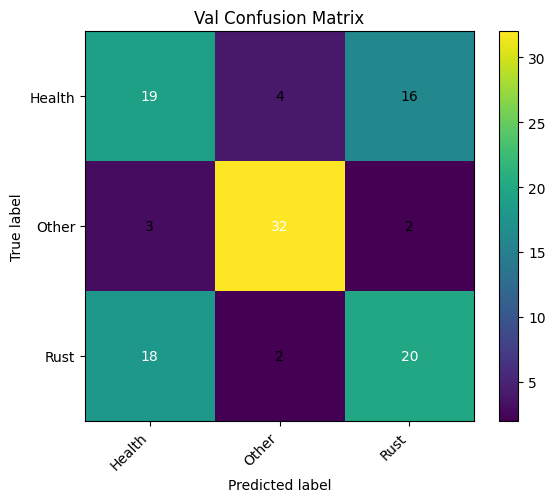

In [22]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    if class_names is None:
        class_names = [str(i) for i in range(len(cm))]
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

class_names = None
if hasattr(val_loader.dataset, "idx_to_class"):
    class_names = [val_loader.dataset.idx_to_class[i] for i in range(len(val_loader.dataset.idx_to_class))]

plot_confusion_matrix(cm, class_names=class_names, title="Val Confusion Matrix")


In [23]:
class HSTestDataset(Dataset):
    """
    Test dataset — pipeline PHẢI khớp HSDataset (trừ augment & label):
    load → ensure_chw → fix_bands → resize → clip_per_band → z-score
    """
    def __init__(self, img_dir, target_bands=125, target_hw=(64, 64), mean=None, std=None):
        self.img_dir = img_dir
        self.target_bands = target_bands
        self.target_hw = target_hw
        self.mean = (torch.tensor(mean).view(target_bands, 1, 1).float()
                     if mean is not None else torch.zeros(target_bands, 1, 1))
        self.std  = (torch.tensor(std).view(target_bands, 1, 1).float()
                     if std is not None else torch.ones(target_bands, 1, 1))
        self.files = sorted([f for f in os.listdir(img_dir)
                             if f.lower().endswith(('.tif', '.tiff'))])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path  = os.path.join(self.img_dir, fname)

        # 1. Load
        arr = tiff.imread(path).astype(np.float32)

        # 2. Ensure CHW  (cùng hàm với train)
        arr = ensure_chw(arr, self.target_bands)

        # 3. Fix bands  (pad spatial-mean, KHÔNG pad 0)
        arr = fix_bands(arr, self.target_bands)

        x = torch.from_numpy(arr)  # (C, H, W)

        # 4. Resize
        if x.shape[1:] != self.target_hw:
            x = F.interpolate(x.unsqueeze(0), size=self.target_hw,
                              mode="bilinear", align_corners=False).squeeze(0)

        # 5. Clip per-band  (TRƯỚC ĐÂY BỊ THIẾU → khiến z-score sai)
        x = clip_per_band(x, 0.01, 0.99)

        # 6. Z-score normalize
        x = (x - self.mean) / (self.std + 1e-8)

        return x, fname


if os.path.exists(TEST_HS_DIR):
    # Load best checkpoint for test prediction
    model.load_state_dict(torch.load(CKPT_PATH, map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()
    print(f"Loaded checkpoint: {CKPT_PATH}")
    print(f"Model on device: {next(model.parameters()).device}")

    test_ds = HSTestDataset(TEST_HS_DIR, TARGET_BANDS, TARGET_HW,
                            mean=mean_stats, std=std_stats)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds = []
    ids = []
    class_names = [train_ds.idx_to_class[i] for i in range(num_classes)]

    with torch.no_grad():
        for x, fname in tqdm(test_loader, desc="Predicting"):
            x = x.to(device)
            out = model(x)
            p_idx = out.argmax(1).cpu().numpy()
            preds.extend([class_names[i] for i in p_idx])
            ids.extend(fname)

    import pandas as pd

    df = pd.DataFrame({"Id": ids, "Category": preds})

    df.to_csv(os.path.join(CHECKPOINT_DIR, "submission_hs.csv"), index=False)    
    print("Saved submission_hs.csv")

Loaded checkpoint: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18.pth
Model on device: cuda:0


Predicting: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]

Saved submission_hs.csv


---

# 🎯 Phase 2: Train ResNet18 với Top-20 Bands

Sử dụng 20 bands được chọn bởi **Hard-Concrete L0 Gate** từ notebook `HardConcrete_TopK_BandSelection.ipynb`.

| | Baseline (125 bands) | Top-K (20 bands) |
|---|---|---|
| Input channels | 125 | 20 |
| Giảm input size | — | **84%** |
| Mục tiêu | Benchmark | Accuracy tương đương với ít bands hơn |

**Selected bands** (sorted): `[7, 32, 43, 48, 50, 58, 72, 84, 92, 97, 98, 99, 101, 105, 110, 111, 112, 114, 117, 122]`

In [24]:
# ===============================================================
# 🎯 Top-K Config
# ===============================================================
# Bands từ Hard-Concrete L0 Gate (sorted by importance)
SELECTED_BANDS = [7, 32, 43, 48, 50, 58, 72, 84, 92, 97, 98, 99,
                  101, 105, 110, 111, 112, 114, 117, 122]
K = len(SELECTED_BANDS)

# Training config cho Top-K model
TOPK_EPOCHS    = 10
TOPK_LR        = 1e-4
TOPK_WD        = 1e-4
TOPK_CKPT_DIR  = CHECKPOINT_DIR  # same dir as baseline
TOPK_CKPT_PATH = os.path.join(TOPK_CKPT_DIR, f"best_hs_topK{K}_resnet18.pth")

print(f"✓ Top-K Config")
print(f"  K = {K} bands: {SELECTED_BANDS}")
print(f"  Epochs = {TOPK_EPOCHS}, LR = {TOPK_LR}")
print(f"  Checkpoint: {TOPK_CKPT_PATH}")

✓ Top-K Config
  K = 20 bands: [7, 32, 43, 48, 50, 58, 72, 84, 92, 97, 98, 99, 101, 105, 110, 111, 112, 114, 117, 122]
  Epochs = 10, LR = 0.0001
  Checkpoint: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs_topK20_resnet18.pth


In [25]:
# ===============================================================
# 🔧 Top-K Datasets + DataLoaders
# ===============================================================
# Wrap existing train_ds / val_ds (đã có mean/std normalize 125 bands)
# SelectBandsDataset chỉ lọc K bands → output: (K, H, W)

topk_train_ds = SelectBandsDataset(train_ds, SELECTED_BANDS)
topk_val_ds   = SelectBandsDataset(val_ds,   SELECTED_BANDS)

topk_train_loader = DataLoader(topk_train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
topk_val_loader   = DataLoader(topk_val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Sanity check
xb_k, yb_k = next(iter(topk_train_loader))
print(f"✓ Top-K DataLoaders created")
print(f"  Train: {len(topk_train_ds)} | Val: {len(topk_val_ds)}")
print(f"  Batch shape: {xb_k.shape}")  # expect [B, 20, 64, 64]
print(f"  Min/Max: {xb_k.min():.3f} / {xb_k.max():.3f}")

✓ Top-K DataLoaders created
  Train: 461 | Val: 116
  Batch shape: torch.Size([32, 20, 64, 64])
  Min/Max: -0.894 / 1.586


In [26]:
# ===============================================================
# 🧠 Top-K ResNet18 Model (K=20 input channels)
# ===============================================================
set_seed(SEED)

topk_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# conv1: K channels thay vì 3 RGB
old_conv = topk_model.conv1
topk_model.conv1 = nn.Conv2d(
    K, old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=False
)
with torch.no_grad():
    topk_model.conv1.weight[:] = (
        old_conv.weight.mean(dim=1, keepdim=True).repeat(1, K, 1, 1)
    )

# fc head
topk_model.fc = nn.Linear(topk_model.fc.in_features, num_classes)
topk_model = topk_model.to(device)

topk_criterion = nn.CrossEntropyLoss()
topk_optimizer = optim.AdamW(topk_model.parameters(), lr=TOPK_LR, weight_decay=TOPK_WD)
topk_scheduler = optim.lr_scheduler.CosineAnnealingLR(topk_optimizer, T_max=TOPK_EPOCHS, eta_min=1e-6)

print(f"✓ Top-K ResNet18 on {device}")
print(f"  Input channels: {K}")
print(f"  Total params: {sum(p.numel() for p in topk_model.parameters()):,}")
print(f"  conv1 weight: {topk_model.conv1.weight.shape}")

✓ Random seed set to 42 for reproducibility
✓ Top-K ResNet18 on cuda
  Input channels: 20
  Total params: 11,231,363
  conv1 weight: torch.Size([64, 20, 7, 7])


In [27]:
# ===============================================================
# 🏋️ Training Loop — Top-K ResNet18
# ===============================================================

def topk_train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def topk_evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

topk_best_acc = 0.0
topk_history = []

print(f"{'='*80}")
print(f"  Training ResNet18 with Top-{K} bands | {TOPK_EPOCHS} epochs")
print(f"  Bands: {SELECTED_BANDS}")
print(f"{'='*80}")

for epoch in range(1, TOPK_EPOCHS + 1):
    train_loss, train_acc = topk_train_one_epoch(
        topk_model, topk_train_loader, topk_optimizer, topk_criterion
    )
    val_loss, val_acc = topk_evaluate(
        topk_model, topk_val_loader, topk_criterion
    )
    topk_scheduler.step()
    
    topk_history.append({
        "epoch": epoch, "train_loss": train_loss, "train_acc": train_acc,
        "val_loss": val_loss, "val_acc": val_acc,
    })
    
    print(f"Epoch {epoch:02d}/{TOPK_EPOCHS} | "
          f"Train: {train_acc:.4f} ({train_loss:.4f}) | "
          f"Val: {val_acc:.4f} ({val_loss:.4f})", end="")
    
    if val_acc > topk_best_acc:
        topk_best_acc = val_acc
        torch.save(topk_model.state_dict(), TOPK_CKPT_PATH)
        print(f" ✅ BEST → {TOPK_CKPT_PATH}")
    else:
        print()

print(f"\n{'='*80}")
print(f"  Done. Best Val Acc = {topk_best_acc:.4f}")
print(f"{'='*80}")

  Training ResNet18 with Top-20 bands | 10 epochs
  Bands: [7, 32, 43, 48, 50, 58, 72, 84, 92, 97, 98, 99, 101, 105, 110, 111, 112, 114, 117, 122]
Epoch 01/10 | Train: 0.4751 (1.0580) | Val: 0.4569 (1.1612) ✅ BEST → D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs_topK20_resnet18.pth
Epoch 02/10 | Train: 0.5944 (0.9106) | Val: 0.5776 (0.9468) ✅ BEST → D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs_topK20_resnet18.pth
Epoch 03/10 | Train: 0.6529 (0.7770) | Val: 0.6034 (0.8436) ✅ BEST → D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs_topK20_resnet18.pth
Epoch 04/10 | Train: 0.6659 (0.7312) | Val: 0.5776 (0.9014)
Epoch 05/10 | Train: 0.7072 (0.6801) | Val: 0.5690 (0.9748)
Epoch 06/10 | Train: 0.7137 (0.6309) | Val: 0.5431 (0.9623)
Epoch 07/10 | Train: 0.7440 (0.5878) | Val: 0.5172 (0.9690)
Epoch 08/10 | Train: 0.7918 (0.5116) | Val: 0.5000 (0.9777)
Epoch 09/10 | Train: 0.7722 (0.5331) | Val: 0.5172 (0.9809)
Epoch 10/10 | Train: 0.7657 (0.5479) | Val: 0.534

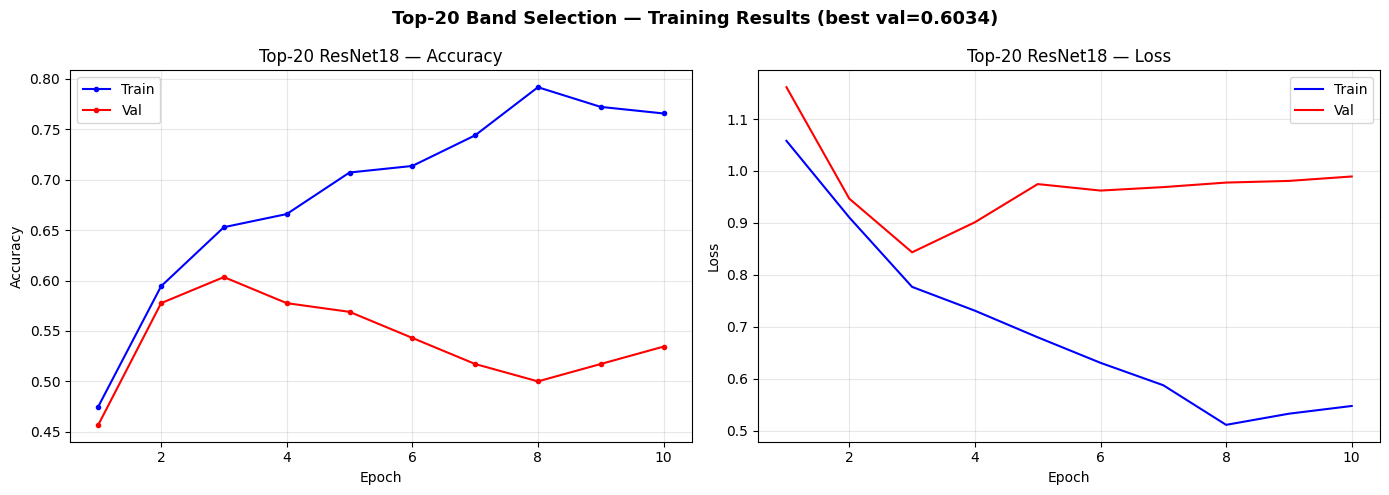

📊 Plot saved


In [28]:
# ===============================================================
# 📊 Training History — Top-K
# ===============================================================
import matplotlib.pyplot as plt

df_topk = pd.DataFrame(topk_history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(df_topk['epoch'], df_topk['train_acc'], 'b-o', markersize=3, label='Train')
ax.plot(df_topk['epoch'], df_topk['val_acc'], 'r-o', markersize=3, label='Val')
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy')
ax.set_title(f'Top-{K} ResNet18 — Accuracy')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(df_topk['epoch'], df_topk['train_loss'], 'b-', label='Train')
ax.plot(df_topk['epoch'], df_topk['val_loss'], 'r-', label='Val')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title(f'Top-{K} ResNet18 — Loss')
ax.legend(); ax.grid(True, alpha=0.3)

plt.suptitle(f'Top-{K} Band Selection — Training Results (best val={topk_best_acc:.4f})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, f"topK{K}_training_history.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"📊 Plot saved")

In [29]:
# ===============================================================
# 📏 Evaluation — Top-K model
# ===============================================================
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

# Load best checkpoint
topk_model.load_state_dict(torch.load(TOPK_CKPT_PATH, map_location=device, weights_only=True))
topk_model.eval()
print(f"✓ Loaded best Top-{K} model from: {TOPK_CKPT_PATH}")

# Get predictions
topk_preds, topk_labels = get_preds_labels(topk_model, topk_val_loader, device)

# Metrics
topk_acc = accuracy_score(topk_labels, topk_preds)
topk_f1_macro = f1_score(topk_labels, topk_preds, average="macro")
topk_f1_weighted = f1_score(topk_labels, topk_preds, average="weighted")

print(f"\n{'='*60}")
print(f"  Top-{K} ResNet18 — Evaluation Results")
print(f"{'='*60}")
print(f"  Accuracy:     {topk_acc:.4f}")
print(f"  F1-macro:     {topk_f1_macro:.4f}")
print(f"  F1-weighted:  {topk_f1_weighted:.4f}")

# Confusion matrix
topk_cm = confusion_matrix(topk_labels, topk_preds)
print(f"\nConfusion Matrix:\n{topk_cm}")

# Classification report
if hasattr(topk_val_ds, "idx_to_class") and topk_val_ds.idx_to_class:
    target_names = [topk_val_ds.idx_to_class[i] for i in range(len(topk_val_ds.idx_to_class))]
else:
    target_names = [train_ds.idx_to_class[i] for i in range(num_classes)]

print(f"\nClassification Report:")
print(classification_report(topk_labels, topk_preds, target_names=target_names, digits=4))

# So sánh với baseline 125 bands
print(f"\n{'='*60}")
print(f"  COMPARISON: 125 bands vs Top-{K} bands")
print(f"{'='*60}")
print(f"  125 bands: best val acc = {best_acc:.4f}  (from Phase 1)")
print(f"  Top-{K}:   best val acc = {topk_best_acc:.4f}")
print(f"  Δ = {topk_best_acc - best_acc:+.4f}")
print(f"  Input reduction: {125} → {K} bands ({(1 - K/125)*100:.1f}% fewer)")
print(f"{'='*60}")

✓ Loaded best Top-20 model from: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs_topK20_resnet18.pth

  Top-20 ResNet18 — Evaluation Results
  Accuracy:     0.6034
  F1-macro:     0.6038
  F1-weighted:  0.6008

Confusion Matrix:
[[20  5 14]
 [ 6 29  2]
 [13  6 21]]

Classification Report:
              precision    recall  f1-score   support

      Health     0.5128    0.5128    0.5128        39
       Other     0.7250    0.7838    0.7532        37
        Rust     0.5676    0.5250    0.5455        40

    accuracy                         0.6034       116
   macro avg     0.6018    0.6072    0.6038       116
weighted avg     0.5994    0.6034    0.6008       116


  COMPARISON: 125 bands vs Top-20 bands
  125 bands: best val acc = 0.6121  (from Phase 1)
  Top-20:   best val acc = 0.6034
  Δ = -0.0086
  Input reduction: 125 → 20 bands (84.0% fewer)


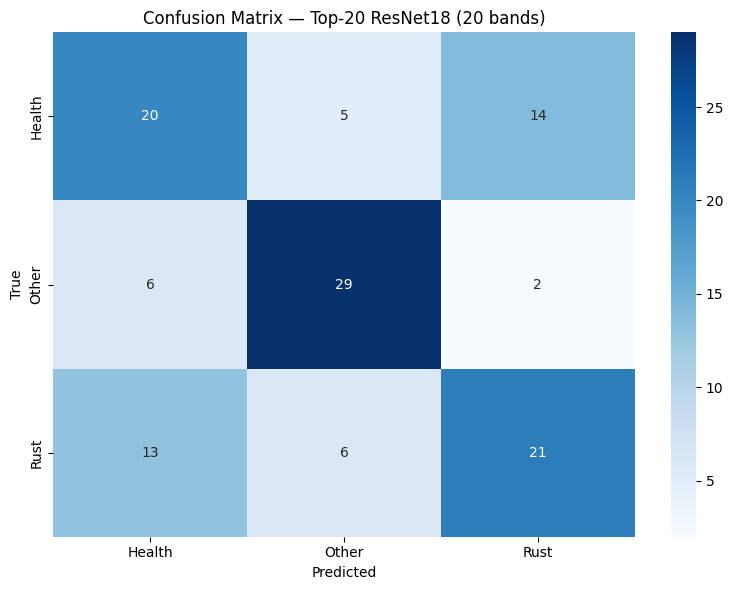

✓ Saved to D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\confusion_matrix_topK20.png


In [30]:
# ===============================================================
# 🎨 Confusion Matrix — Top-K model
# ===============================================================
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(topk_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"Confusion Matrix — Top-{K} ResNet18 ({K} bands)")
plt.tight_layout()

cm_path = os.path.join(TOPK_CKPT_DIR, f"confusion_matrix_topK{K}.png")
plt.savefig(cm_path, dpi=150)
plt.show()
print(f"✓ Saved to {cm_path}")

In [31]:
# ===============================================================
# 📤 Test Submission — Top-K model
# ===============================================================
import pandas as pd

# Re-use HSTestDataset already defined in the 125-band baseline section.
# It processes: load → ensure_chw → fix_bands → resize → clip_per_band → z-score
# Returns (x, fname) where fname is e.g. "image_001.tif"

if os.path.exists(TEST_HS_DIR):
    # Load best Top-K checkpoint
    topk_model.load_state_dict(torch.load(TOPK_CKPT_PATH, map_location=device, weights_only=True))
    topk_model = topk_model.to(device)
    topk_model.eval()
    print(f"✓ Loaded Top-{K} checkpoint: {TOPK_CKPT_PATH}")

    # Build test dataset with ALL 125 bands, then filter to K
    test_ds_full = HSTestDataset(TEST_HS_DIR, TARGET_BANDS, TARGET_HW,
                                 mean=mean_stats, std=std_stats)
    topk_test_ds = SelectBandsDataset(test_ds_full, SELECTED_BANDS)
    topk_test_loader = DataLoader(topk_test_ds, batch_size=BATCH_SIZE, shuffle=False)
    print(f"✓ Test dataset: {len(topk_test_ds)} samples, {K} bands")

    # Predict
    class_names = [train_ds.idx_to_class[i] for i in range(num_classes)]
    preds = []
    ids = []

    with torch.no_grad():
        for x, fname in tqdm(topk_test_loader, desc="Top-K Predicting"):
            x = x.to(device)
            out = topk_model(x)
            p_idx = out.argmax(1).cpu().numpy()
            preds.extend([class_names[i] for i in p_idx])
            ids.extend(fname)

    # Save submission
    df = pd.DataFrame({"Id": ids, "Category": preds})
    submission_path = os.path.join(TOPK_CKPT_DIR, f"submission_hs_topK{K}.csv")
    df.to_csv(submission_path, index=False)
    print(f"✓ Saved {submission_path}")
    print(f"  {len(df)} predictions")
    print(f"\nLabel distribution:")
    print(df["Category"].value_counts())
else:
    print(f"⚠ TEST_HS_DIR not found: {TEST_HS_DIR}")

✓ Loaded Top-20 checkpoint: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs_topK20_resnet18.pth
✓ Test dataset: 300 samples, 20 bands


Top-K Predicting: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]

✓ Saved D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_hs_topK20.csv
  300 predictions

Label distribution:
Category
Other     134
Health     87
Rust       79
Name: count, dtype: int64
